In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
from tensorflow.keras import layers, models
import keras_tuner as kt
import tensorflow as tf

c:\Users\skhan\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
# Doing basic EDA and data cleaning.
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [4]:
# Target variable is Churn.
# Simple encoding using map function and converting to numeric.
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df.isnull().sum()
df.dropna(inplace=True)



In [5]:
# 11 data is found to be missing.this is not a big deal.so we can drop them.
df.info()




<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   int64  
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 
 17  

In [6]:


# Feature selection.
#Converting data into numeric for RFE:
numeric_features = ['gender','SeniorCitizen','tenure', 'MonthlyCharges', 'TotalCharges','TechSupport','OnlineSecurity','StreamingMovies', 'Dependents','PaymentMethod']
for feature in numeric_features:
    if df[feature].dtype == 'object':
        df[feature] = pd.factorize(df[feature])[0]

print(feature)
numeric_features=[f for f in numeric_features if f in df.columns]
numeric_features

PaymentMethod


['gender',
 'SeniorCitizen',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'TechSupport',
 'OnlineSecurity',
 'StreamingMovies',
 'Dependents',
 'PaymentMethod']

In [7]:
X=df[numeric_features]
y=df['Churn']

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           7032 non-null   int64  
 1   SeniorCitizen    7032 non-null   int64  
 2   tenure           7032 non-null   int64  
 3   MonthlyCharges   7032 non-null   float64
 4   TotalCharges     7032 non-null   float64
 5   TechSupport      7032 non-null   int64  
 6   OnlineSecurity   7032 non-null   int64  
 7   StreamingMovies  7032 non-null   int64  
 8   Dependents       7032 non-null   int64  
 9   PaymentMethod    7032 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 604.3 KB


In [9]:
#Lets use RFE to select the top 5 features:
model=RandomForestClassifier(n_estimators=150, random_state=42)
rfe=RFE(estimator=model, n_features_to_select=5)
rfe=rfe.fit(X,y)
print(rfe.support_)
print(rfe.ranking_)



[False False  True  True  True False  True False False  True]
[4 5 1 1 1 2 1 3 6 1]


In [10]:
model.fit(X,y)


RandomForestClassifier(n_estimators=150, random_state=42)

In [11]:
importance=pd.DataFrame({'Feature':numeric_features,'Importance':model.feature_importances_})
importance=importance.sort_values(by='Importance',ascending=False)
selected=importance.iloc[:,:]
selected






,Feature,Importance
4,TotalCharges,0.264309
3,MonthlyCharges,0.254192
2,tenure,0.202364
9,PaymentMethod,0.064704
6,OnlineSecurity,0.063623
5,TechSupport,0.054614
0,gender,0.028899
7,StreamingMovies,0.025794
1,SeniorCitizen,0.020772
8,Dependents,0.020728


In [12]:
selected_features=[feature for feature,selected in zip(numeric_features,rfe.support_) if selected]
selected_features






['tenure', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity', 'PaymentMethod']

C:\Users\skhan\AppData\Local\Temp\ipykernel_18748\3094563669.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


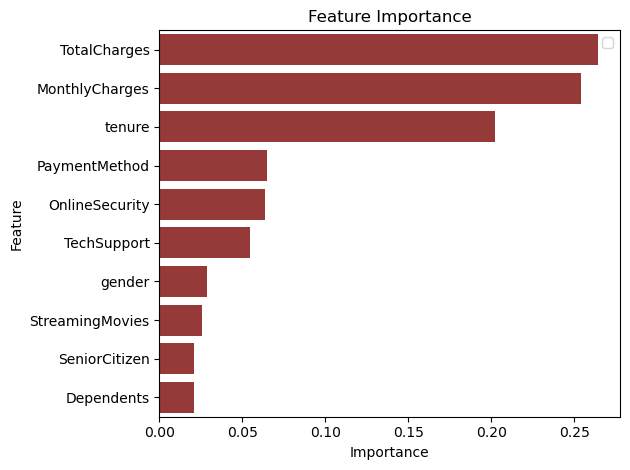

In [13]:
sns.barplot(x='Importance',y='Feature',data=importance,orient='h',color='brown')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.legend()
plt.show()





In [14]:
# Here we can see that tenure, MonthlyCharges and TotalCharges are the most important features.
# Lets use these features to build a model.

In [15]:
# Creationg dataset for model:
X1=df[selected_features]
y=df['Churn']

In [16]:
X1

,tenure,MonthlyCharges,TotalCharges,OnlineSecurity,PaymentMethod
0,1,29.85,29.85,0,0
1,34,56.95,1889.50,1,1
2,2,53.85,108.15,1,1
3,45,42.30,1840.75,1,2
4,2,70.70,151.65,0,0
...,...,...,...,...,...
7038,24,84.80,1990.50,1,1
7039,72,103.20,7362.90,0,3
7040,11,29.60,346.45,1,0
7041,4,74.40,306.60,0,1


In [17]:
y.head(2)

0    0
1    0
Name: Churn, dtype: int64

In [18]:
X_train,X_test,y_train,y_test=train_test_split(X1,y,test_size=0.2,random_state=42)

In [19]:
# Scaling the data using standard scaler:
scale=StandardScaler()
X_train_scaled=scale.fit_transform(X_train)
X_test_scaled=scale.transform(X_test)
with open('scale.pkl', 'wb') as f:
    pickle.dump(scale,f)

In [20]:
# Now create the models using tensorfloe,keras and sequential
def create_model(hp=None):
    if hp:
        model=models.Sequential()
        # First layer
        model.add(layers.Dense(
            units=hp.Choice('unit1',values=[32,64,128]),
            input_shape=(X_train_scaled.shape[1],),
            activation='relu'))
        # 2nd layer
        if hp.Boolean('second_layer'):
             model.add(layers.Dense(
                units=hp.Choice('unit2',values=[32,16,8]),
                activation='relu'))
        # Output layer
        model.add(layers.Dense(1,activation='sigmoid'))
         # model Compiling
        model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
        
    else:
         model=models.Sequential([
             layers.Dense(64,activation='relu',input_shape=(X_train_scaled.shape[1],)),
             layers.Dense(32,activation='relu'),
             layers.Dense(16,activation='relu'),
             layers.Dense(8,activation='relu'),
             layers.Dense(1,activation='sigmoid'),  

         ]
           
         )
         model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [21]:
initial_model=create_model()

c:\Users\skhan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
initial_model

<Sequential name=sequential, built=True>

In [23]:
initial_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history=initial_model.fit(X_train_scaled,y_train,epochs=50,batch_size=32,validation_split=0.20)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7482 - loss: 0.4989 - val_accuracy: 0.7929 - val_loss: 0.4509
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7849 - loss: 0.4543 - val_accuracy: 0.8071 - val_loss: 0.4360
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7880 - loss: 0.4458 - val_accuracy: 0.8133 - val_loss: 0.4283
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7887 - loss: 0.4420 - val_accuracy: 0.8044 - val_loss: 0.4246
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7962 - loss: 0.4394 - val_accuracy: 0.8142 - val_loss: 0.4207
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7978 - loss: 0.4359 - val_accuracy: 0.8116 - val_loss: 0.4180
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7962 - loss: 0.4366 - val_accuracy: 0.8027 - val_loss: 0.4209
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8020 - loss: 0.4316 - val_accuracy: 0.

In [25]:
# Model Evaluation

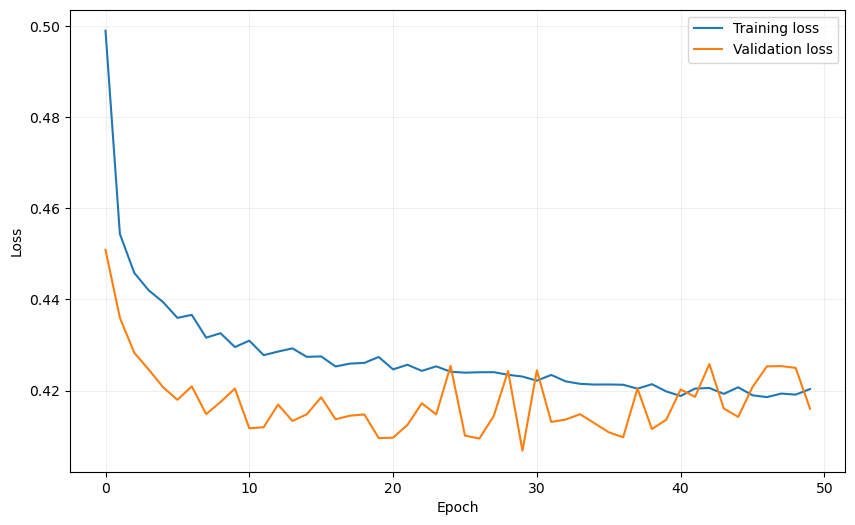

In [26]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True,alpha=0.2)

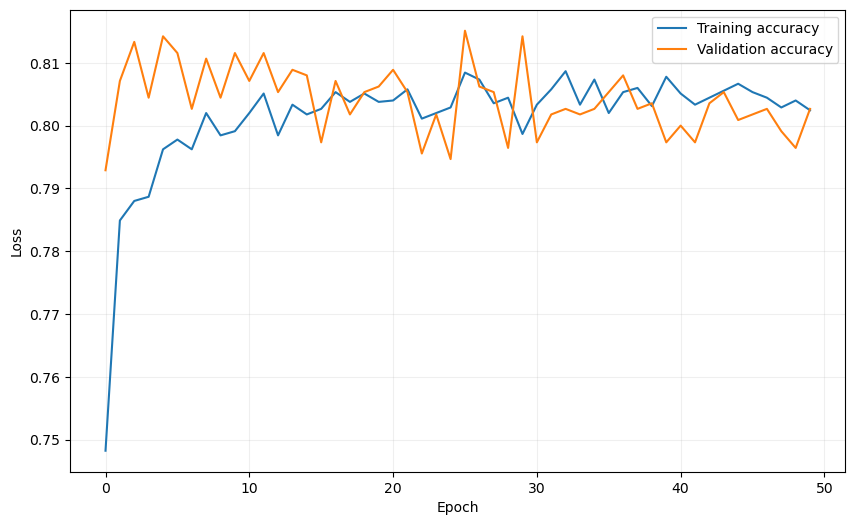

In [27]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'],label='Training accuracy')
plt.plot(history.history['val_accuracy'],label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True,alpha=0.2)

In [28]:
loss, accuracy=initial_model.evaluate(X_test_scaled,y_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7910 - loss: 0.4509


In [29]:
print('The Hyperparametre strarts from here....')
tuner=kt.RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=5,
    directory='keras_tunning_training loss',
    project_name='Churn_prediction'
)
stop_early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3)
tuner.search(X_train_scaled,y_train,epochs=20,validation_split=0.2,callbacks=[stop_early])

The Hyperparametre strarts from here....
Reloading Tuner from keras_tunning_training loss\Churn_prediction\tuner0.json


In [30]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
for param in best_hps.values:
 print(f"{param}:{best_hps.get(param)}")

unit1:128
second_layer:False
unit2:16


In [31]:
best_model=tuner.hypermodel.build(best_hps)
best_history=best_model.fit(X_train_scaled,y_train,epochs=50,batch_size=30, validation_split=0.20)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7633 - loss: 0.5029 - val_accuracy: 0.8044 - val_loss: 0.4438
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7829 - loss: 0.4546 - val_accuracy: 0.8044 - val_loss: 0.4358
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7847 - loss: 0.4484 - val_accuracy: 0.8107 - val_loss: 0.4322
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7873 - loss: 0.4446 - val_accuracy: 0.8080 - val_loss: 0.4285
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7911 - loss: 0.4421 - val_accuracy: 0.8089 - val_loss: 0.4257
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7907 - loss: 0.4406 - val_accuracy: 0.8071 - val_loss: 0.4236
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7918 - loss: 0.4393 - val_accuracy: 0.8080 - val_loss: 0.4240
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7962 - loss: 0.4386 - val_accuracy: 0.

In [32]:
best_loss,best_accuracy=best_model.evaluate(X_test_scaled,y_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7825 - loss: 0.4461


In [33]:
best_loss

0.44610968232154846

In [34]:
best_accuracy


0.7825160026550293

In [35]:
best_model.save('best_model.h5')
print('Best model saved in local system')
with open('selected_features','wb') as f:
    pickle.dump(selected_features,f)

Best model saved in local system


In [36]:
def load_model_component():
    model=tf.keras.models.load_model('best_model.h5')
# Loading scalar component
    with open('scale.pkl','rb') as f:
        scalar=pickle.load(f)
# Loading selected features:
    with open('selected_features','rb')as f:
        scaled_features=pickle.load(f)
    return model,scalar,scaled_features

In [37]:
def predict_churn_from_user():
    model, scaler, selected_features = load_model_component()

    user_input = {}

    print("Enter values for the following features:")

    for feature in selected_features:
        while True:
            try:
                value = float(input(f"{feature}: "))
                user_input[feature] = value
                break
            except ValueError:
                print("❌ Invalid input. Please enter a numeric (float) value.")

    # Convert input to DataFrame
    sample_customer = pd.DataFrame([user_input])

    # Scale input
    sample_scaled = scaler.transform(sample_customer)

    # Predict
    prediction = float(model.predict(sample_scaled)[0][0])

    # Output
    print("\n--- Prediction Result ---")
    print(f"Churn probability: {prediction:.2f}")
    print(f"Will churn: {'Yes' if prediction > 0.5 else 'No'}")

    return prediction





In [ ]:
result=predict_churn_from_user()


Enter values for the following features:
